In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [3]:
data = pd.read_csv("wb_reviews.csv")

In [4]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 7 else 0)

In [5]:
data

,Name,Description,Review,Rating,Sentiment
0,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Хорошо моет,10,1
1,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"При первом использовании заметил ,что мочалка ...",2,0
2,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Супер всё!,10,1
3,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,"Пошита, на первый взгляд, не плохо. Мылится не...",10,1
4,Мочалка для душа Grizzly XXL для тела черная,Готовы к незабываемым впечатлениям в душе? «Gr...,Слишком мягкая,2,0
...,...,...,...,...,...
196940,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Прекрасный звонок. У нас получилась дальность ...,10,1
196941,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,Всё супер. Звонок просто ВАУУУ,10,1
196942,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Классный звонок, сколько у нас из было,этот са...",10,1
196943,Звонок дверной беспроводной на батарейках,Звонок дверной беспроводной влагозащищенный ул...,"Звенит звонко Нет Очень хороший звоночек, мн...",10,1


# SVM

In [6]:
data_clean = data.copy()

In [7]:
def count_russian_chars(s: str) -> int:
    return len(re.findall(r'[а-яА-Я]', s))

data_clean['Russian chars'] = data_clean['Review'].apply(lambda x: count_russian_chars(str(x)))

In [8]:
data_clean_russian = data_clean[data_clean['Russian chars'] > 0]
data_clean_russian = data_clean_russian.reset_index(drop=True)

In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

stemmer = SnowballStemmer("russian")

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text, language="russian")
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gfgh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
data_clean_russian['Review'] = data_clean_russian['Review'].apply(lambda x: preprocess_text(str(x)))
print(data_clean_russian.head())

                                           Name  \
0  Мочалка для душа Grizzly XXL для тела черная   
1  Мочалка для душа Grizzly XXL для тела черная   
2  Мочалка для душа Grizzly XXL для тела черная   
3  Мочалка для душа Grizzly XXL для тела черная   
4  Мочалка для душа Grizzly XXL для тела черная   

                                         Description  \
0  Готовы к незабываемым впечатлениям в душе? «Gr...   
1  Готовы к незабываемым впечатлениям в душе? «Gr...   
2  Готовы к незабываемым впечатлениям в душе? «Gr...   
3  Готовы к незабываемым впечатлениям в душе? «Gr...   
4  Готовы к незабываемым впечатлениям в душе? «Gr...   

                                              Review  Rating  Sentiment  \
0                                         хорош моет      10          1   
1  при перв использован замет что мочалк осыпа вс...       2          0   
2                                          супер все      10          1   
3  пошит на перв взгляд не плох мыл не особ хорош...    

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [12]:
pipeline = Pipeline([
    ('tf-idf', TfidfVectorizer(ngram_range=(1,3))),
    ('clf', SVC(C=1, kernel='linear'))
])

In [13]:
pipeline.fit(X_train['Review'], y_train)

Pipeline(steps=[('tf-idf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', SVC(C=1, kernel='linear'))])

In [14]:
pred = pipeline.predict(X_test['Review'])
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      6839
           1       0.96      0.97      0.96     41874

    accuracy                           0.93     48713
   macro avg       0.87      0.85      0.86     48713
weighted avg       0.93      0.93      0.93     48713



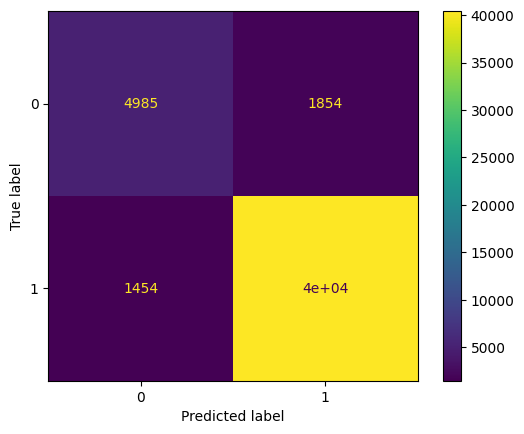

In [15]:
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test['Review'], y_test)

Однако здесь мы использовали только сам отзыв, применим также наши знания в областях описания и имени!


In [16]:
data_clean_russian['Name'] = data_clean_russian['Name'].apply(lambda x: preprocess_text(str(x)))
data_clean_russian["Description"] = data_clean_russian["Description"].apply(lambda x: preprocess_text(str(x)))
print(data_clean_russian.head())

                                      Name  \
0  мочалк для душ grizzly xxl для тел черн   
1  мочалк для душ grizzly xxl для тел черн   
2  мочалк для душ grizzly xxl для тел черн   
3  мочалк для душ grizzly xxl для тел черн   
4  мочалк для душ grizzly xxl для тел черн   

                                         Description  \
0  готов к незабыва впечатлен в душ гриззл больш ...   
1  готов к незабыва впечатлен в душ гриззл больш ...   
2  готов к незабыва впечатлен в душ гриззл больш ...   
3  готов к незабыва впечатлен в душ гриззл больш ...   
4  готов к незабыва впечатлен в душ гриззл больш ...   

                                              Review  Rating  Sentiment  \
0                                         хорош моет      10          1   
1  при перв использован замет что мочалк осыпа вс...       2          0   
2                                          супер все      10          1   
3  пошит на перв взгляд не плох мыл не особ хорош...      10          1   
4          

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[["Name", "Description", "Review"]],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

In [18]:
tf_idf_processor = ColumnTransformer(transformers=[
    ("tf-idf_name", TfidfVectorizer(ngram_range=(1, 2)), "Name"),
    ("tf-idf_desc", TfidfVectorizer(ngram_range=(1, 2)), "Description"),
    ("tf-idf_review", TfidfVectorizer(ngram_range=(1, 3)), "Review")
])

In [19]:
pipeline = Pipeline([
    ("tf-idf_columns", tf_idf_processor),
    ("clf", SVC(C=1, kernel="linear"))
])

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tf-idf_columns',
                 ColumnTransformer(transformers=[('tf-idf_name',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'Name'),
                                                 ('tf-idf_desc',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'Description'),
                                                 ('tf-idf_review',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               3)),
                                                  'Review')])),
                ('clf', SVC(C=1, kernel='linear'))])

              precision    recall  f1-score   support

           0       0.78      0.73      0.75      6839
           1       0.96      0.97      0.96     41874

    accuracy                           0.93     48713
   macro avg       0.87      0.85      0.86     48713
weighted avg       0.93      0.93      0.93     48713



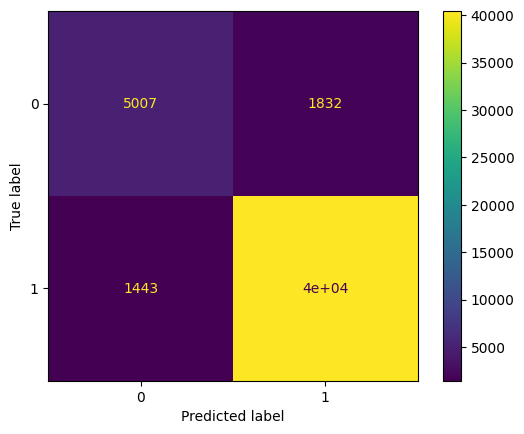

In [21]:
pred = pipeline.predict(X_test)
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

Добавим немного экспериментов с параметрами! Попробуем перейти на другое ядро - rbf, а также поиграться с параметром C.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_clean_russian[['Review']],
                                                    data_clean_russian['Sentiment'],
                                                    stratify=data_clean_russian['Sentiment'],
                                                    test_size=0.25,
                                                    random_state=42)

C = 1
              precision    recall  f1-score   support

           0       0.80      0.68      0.73      6839
           1       0.95      0.97      0.96     41874

    accuracy                           0.93     48713
   macro avg       0.87      0.83      0.85     48713
weighted avg       0.93      0.93      0.93     48713



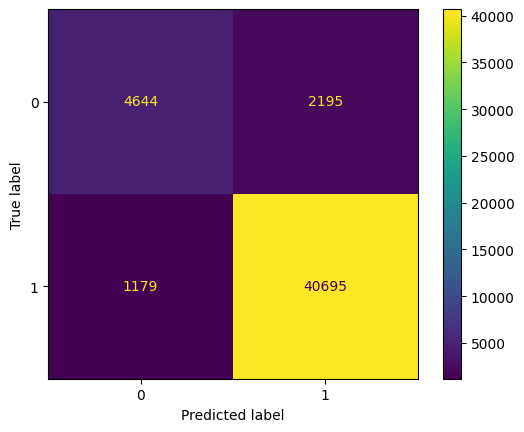

In [29]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=1, kernel="rbf"))
])

print('='*50)
print("C = 1")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

C = 0.1
              precision    recall  f1-score   support

           0       0.89      0.05      0.10      6839
           1       0.87      1.00      0.93     41874

    accuracy                           0.87     48713
   macro avg       0.88      0.53      0.51     48713
weighted avg       0.87      0.87      0.81     48713



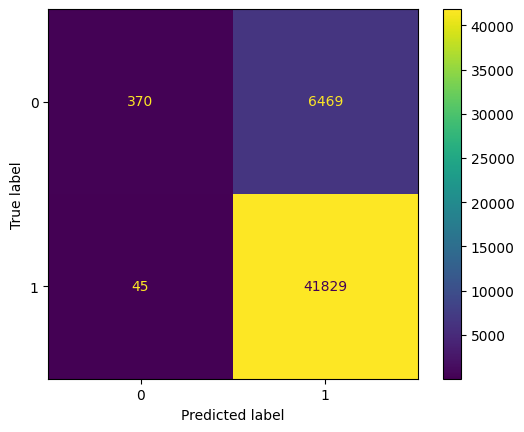

In [30]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=0.1, kernel="rbf"))
])

print('='*50)
print("C = 0.1")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)

C = 10
              precision    recall  f1-score   support

           0       0.79      0.71      0.74      6839
           1       0.95      0.97      0.96     41874

    accuracy                           0.93     48713
   macro avg       0.87      0.84      0.85     48713
weighted avg       0.93      0.93      0.93     48713



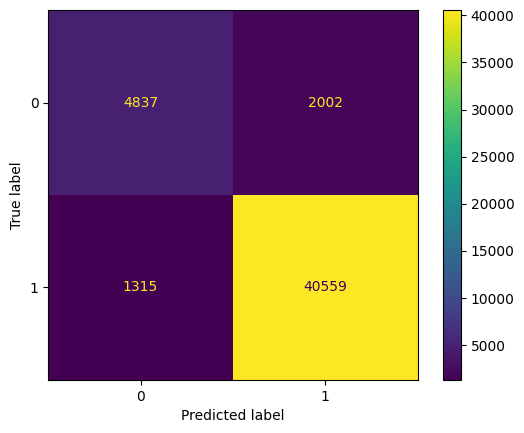

In [31]:
pipeline = Pipeline([
    ("tf-idf", TfidfVectorizer(ngram_range=(1, 3))),
    ("clf", SVC(C=10, kernel="rbf"))
])

print('='*50)
print("C = 10")
pipeline.fit(X_train["Review"], y_train)
pred = pipeline.predict(X_test["Review"])
print(classification_report(y_test, pred))
_ = ConfusionMatrixDisplay.from_estimator(pipeline, X_test["Review"], y_test)
print('='*50)